### Gradient Boosted Decision Tree and Fairness Example

#### Data Loading and Preparation

In [43]:
import pandas as pd
from modeva import DataSet # Import Data Processing Library
from modeva import TestSuite # Import Testing Library
df = pd.read_csv("credit_example.csv") # Loading data into pd dataframe
ds = DataSet() # Create dataset object holder
ds.load_dataframe(data = df) 
df

,Mortgage,Balance,Amount Past Due,Delinquency,Inquiry,Open Trade,Utilization,Gender,Race,Status
0,139734.22,2717.87,0.00,0,0,0,0.785162,0,0,0
1,243359.62,193.60,0.00,0,0,0,0.254759,0,0,1
2,187784.19,395.05,0.00,0,1,0,0.360995,0,0,1
3,594626.89,180.94,0.00,0,0,0,0.128144,0,1,1
4,166771.42,1241.13,0.00,0,0,0,0.702958,0,0,0
...,...,...,...,...,...,...,...,...,...,...
19995,226806.34,670.99,0.00,0,1,0,0.922122,0,1,1
19996,308625.65,3223.94,0.00,0,0,0,0.989716,1,1,1
19997,375035.34,133.05,131.15,1,0,0,0.092523,0,0,1
19998,165377.42,2256.07,0.00,0,0,0,0.630330,1,0,1


##### Data Preprocessing

In [44]:
ds.encode_categorical(method="ordinal") # Encoding categorical variables as ordinal
ds.scale_numerical(features=tuple(ds.feature_names_numerical), 
                   method="standardize") # standardized numerical features
ds.set_inactive_features(['Gender','Race'])  # Exclude Gender and Race from modeling
ds.set_target('Status') # set target
ds.preprocess() # Run pre-processing
ds.set_random_split(test_ratio = 0.2) # Split training and testing

#### Train monotonic xgboost by applying monotonicity constraints

In [45]:
from modeva.models import MoXGBClassifier             # Import xgboost library
# for xgboost with monotonic constraints
model_xgb2_mono = MoXGBClassifier(name = "XGB2_Mono", max_depth=2, 
                                  n_estimators = 300,
                                  learning_rate = 0.1,
                                  monotone_constraints="(1, 1, -1, -1, -1, -1, -1)")
# train model with input: ds.train_x and target: ds.train_y
model_xgb2_mono.fit(ds.train_x, ds.train_y)

MoXGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, missing=nan,
                monotone_constraints='(1, 1, -1, -1, -1, -1, -1)',
                multi_strategy=None, n_estimators=300, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic', ...)

In [46]:
ts_xgb2_mono = TestSuite(ds, model_xgb2_mono) # store bundle of dataset and model in ts
# View model performance metrics 
results_xgb2_mono = ts_xgb2_mono.diagnose_accuracy_table()
results_xgb2_mono.table

,AUC,ACC,F1,LogLoss,Brier
train,0.848142,0.767375,0.795315,0.479263,0.158045
test,0.845525,0.770750,0.795084,0.483798,0.159026
GAP,-0.002617,0.003375,-0.000231,0.004534,0.000982


In [47]:
# Check feature importance
results_xgb2_mono = ts_xgb2_mono.interpret_ei()
results_xgb2_mono.plot(n_bars=10, figsize=(5,4))

In [48]:
# Check feature effect of most important feature
results_xgb2_mono = ts_xgb2_mono.interpret_effects(features = "Utilization", grid_size=200)
results_xgb2_mono.plot(figsize = (6,4))

#### Setting “protected data” status for fairness evaluation

In [49]:
#set protected data
ds.set_protected_data(ds.raw_data[["Gender", "Race"]])
# Create configuration to define protected and reference groups
group_config = {
   "Gender": {"feature": "Gender", "protected": 0.0, "reference": 1.0},
   "Race": {"feature": "Race", "protected": 0.0, "reference": 1.0},
}

# Evaluate model fairness
results = ts_xgb2_mono.diagnose_fairness(group_config=group_config,
                            favorable_label=1,
                            metric="AIR",
                            threshold=0.8)
results.plot()

#### Slicing for Fairness Diagnostics

##### Univariate Slicing

In [50]:
results = ts_xgb2_mono.diagnose_slicing_fairness(features="Mortgage",
                                    group_config=group_config,
                                    dataset="test",
                                    metric="AIR")
results.plot()

##### Bivariate Slicing

In [51]:
results = ts_xgb2_mono.diagnose_slicing_fairness(features=("Mortgage", "Balance"),
                                    group_config=group_config,
                                    dataset="train",
                                    metric="AIR",
                                    threshold=0.9)
results.plot()

##### Evaluation for All Features

In [52]:
# Create tuple for feature list in ds.features_names
feature_names = tuple((x,) for x in ds.feature_names)
results = ts_xgb2_mono.diagnose_slicing_fairness(features=feature_names,
                                    group_config=group_config,
                                    dataset="train",
                                    metric="AIR",
                                    threshold = 0.8,
                                    method="auto-xgb1", bins=5)
results.table["Gender"]

,Feature,Segment,Size,AIR,Threshold,Weak
0,Amount Past Due,"[1.04, 17.19]",1389,0.134656,0.8,True
1,Amount Past Due,"[0.26, 1.04)",1408,0.182143,0.8,True
2,Amount Past Due,"[-0.04, 0.26)",1230,0.244947,0.8,True
3,Delinquency,"[1.74, 2.34]",2318,0.336645,0.8,True
4,Amount Past Due,"[-0.27, -0.04)",1391,0.369311,0.8,True
5,Mortgage,"[-1.39, -0.83)",3255,0.414787,0.8,True
6,Delinquency,"[1.14, 1.74)",767,0.432094,0.8,True
7,Delinquency,"[0.53, 1.14)",1141,0.518559,0.8,True
8,Delinquency,"[-0.07, 0.53)",2597,0.530572,0.8,True
9,Open Trade,"[1.75, 12.60]",2673,0.560455,0.8,True


#### Compare with less granular model

In [53]:
# for xgboost with monotonic constraints
model_xgb2_mono2 = MoXGBClassifier(name = "XGB2_Mono2", max_depth=2, 
                                  n_estimators = 50,
                                  learning_rate = 0.1,
                                  monotone_constraints="(1, 1, -1, -1, -1, -1, -1)")
# train model with input: ds.train_x and target: ds.train_y
model_xgb2_mono2.fit(ds.train_x, ds.train_y)

MoXGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, missing=nan,
                monotone_constraints='(1, 1, -1, -1, -1, -1, -1)',
                multi_strategy=None, n_estimators=50, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic', ...)

In [54]:
tsc = TestSuite(ds, models=[model_xgb2_mono, model_xgb2_mono2])
results = tsc.compare_fairness(group_config=group_config, metric="AIR", threshold=0.8)
results.plot()

#### Run Number of Boosting and Learning Rate to Find Best Trades Off

In [55]:
from modeva.models import MoXGBClassifier
from modeva.models import ModelTuneRandomSearch
param_grid = {"n_estimators": [20, 50, 100, 300],
              "learning_rate": [0.01, 0.1, 0.3]}
model = MoXGBClassifier(max_depth=2, monotone_constraints="(1, 1, -1, -1, -1, -1, -1)")
hpo = ModelTuneRandomSearch(dataset=ds, model=model)
hpo_result = hpo.run(param_distributions=param_grid,
                 metric=("AUC", "ACC", "LogLoss", "Brier"),
                 n_iter=20,
                 cv=5)
hpo_result.table

,n_estimators,learning_rate,AUC,ACC,LogLoss,Brier,AUC_rank,ACC_rank,LogLoss_rank,Brier_rank,Time
7,300,0.10,0.838027,0.758438,0.493099,0.163268,1,2,1,1,4.268198
10,100,0.30,0.837880,0.759000,0.493381,0.163407,2,1,2,2,1.457462
9,50,0.30,0.837498,0.756437,0.494066,0.163607,3,4,3,3,0.747900
11,300,0.30,0.837481,0.758250,0.494539,0.163679,4,3,4,4,2.601066
6,100,0.10,0.835938,0.756437,0.497980,0.164639,5,4,5,5,1.384177
8,20,0.30,0.831408,0.753375,0.505280,0.167183,6,6,6,6,0.317100
5,50,0.10,0.828507,0.751125,0.511151,0.169011,7,7,7,7,0.609426
3,300,0.01,0.820926,0.743062,0.526623,0.174455,8,8,8,8,3.874480
4,20,0.10,0.814235,0.741312,0.539833,0.179401,9,9,9,9,0.251742
2,100,0.01,0.802419,0.735375,0.571622,0.192163,10,10,10,10,1.288418


In [56]:
res_table = []
group_config = {
    "Gender": {"feature": "Gender", "protected": 0, "reference": 1},
    "Race": {"feature": "Race", "protected": 0, "reference": 1},
}
for idx in range(hpo_result.table.shape[0]):
    params = {key: hpo_result.table[key].iloc[idx] for key in param_grid.keys()}
    model = MoXGBClassifier(**params, max_depth=2, monotone_constraints="(1, 1, -1, -1, -1, -1, -1)")
    model.fit(ds.train_x, ds.train_y)

    # Calculate adverse impact ratio (AIR)
    ts = TestSuite(ds, model)
    auc_results = ts.diagnose_accuracy_table()

    air_results = ts.diagnose_fairness(group_config=group_config,
                                       favorable_label=1,
                                       dataset="test",
                                       metric="AIR")

    res_table.append({**params,
                      "CV-AUC": hpo_result.table["AUC"].iloc[idx],
                      "Test-AUC": auc_results.value['AUC']['test'],
                      "Gender-AIR": air_results.table['Gender'].values[0],
                     "Race-AIR": air_results.table['Gender'].values[0]})
res_table = pd.DataFrame(res_table)
res_table

,n_estimators,learning_rate,CV-AUC,Test-AUC,Gender-AIR,Race-AIR
0,300,0.10,0.838027,0.845525,0.789366,0.789366
1,100,0.30,0.837880,0.845584,0.798712,0.798712
2,50,0.30,0.837498,0.844362,0.826893,0.826893
3,300,0.30,0.837481,0.845664,0.792846,0.792846
4,100,0.10,0.835938,0.842283,0.859063,0.859063
5,20,0.30,0.831408,0.837020,0.924769,0.924769
6,50,0.10,0.828507,0.834032,0.931207,0.931207
7,300,0.01,0.820926,0.823891,0.991318,0.991318
8,20,0.10,0.814235,0.816120,1.007512,1.007512
9,100,0.01,0.802419,0.803604,1.011079,1.011079


#### Plot AUC vs. AIR for Efficient Frontier

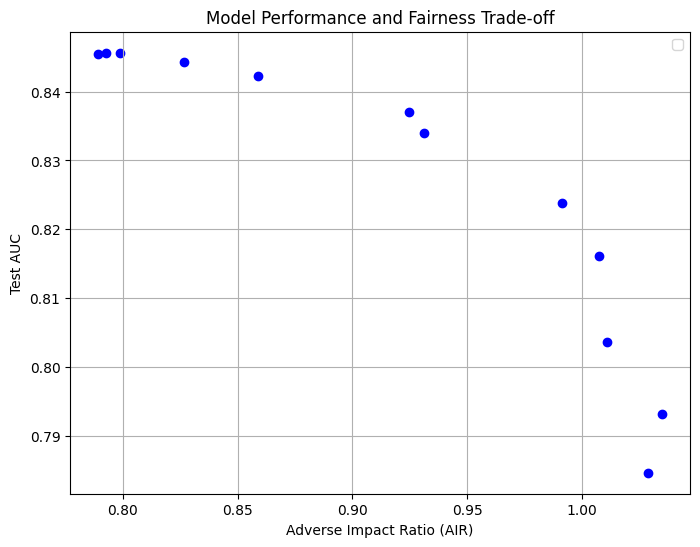

In [57]:
from matplotlib import pylab as plt

plt.figure(figsize=(8, 6))
plt.scatter(res_table['Gender-AIR'], res_table['Test-AUC'], c='blue')
plt.ylabel('Test AUC')
plt.xlabel('Adverse Impact Ratio (AIR)')
plt.title('Model Performance and Fairness Trade-off')
plt.grid(True)
plt.legend()
plt.show()